<a href="https://colab.research.google.com/github/wFairmanOlin/Biomass/blob/master/Prediction_new.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install --upgrade pip

In [ ]:
import numpy as np
import json
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import pandas as pd
from datetime import datetime
import firebase_admin
from firebase_admin import db
from firebase_admin import credentials
import pytz

# Import from Firebase

To download data from firebase, you must have a unique key stored locally. The key will not be available from github and should not be uploaded to github. The following code currently downloads all the data from Firebase, as our database grows, future versions should look into only downloading the latest data

In [ ]:
### ONLY RUN ONCE! ###
#download data from firebase
cred = credentials.Certificate("/content/haucs-monitoring-firebase-adminsdk-wt1pb-1291f2083e.json")
firebase_admin.initialize_app(cred, {'databaseURL': 'https://haucs-monitoring-default-rtdb.firebaseio.com'})

In [ ]:
## ONLY RUN TO REFRESH DATA! ###
ref = db.reference('/')
data = ref.get()

### RUN TO SAVE JSON FILE LOCALLY ###
with open('latest_data.json', 'w') as f:
    json.dump(data, f)

# Date Time
Firebase stores the time of data entries as a local datetime string. Due to daylight savings issues, we have to be careful with how to process datetime objects. The following code block handles converting local datetime objects into timezone aware datetime objects.

For data analysis, the date time objects should probably be converted into timestamps.

In [ ]:
def to_datetime(dates, tz_aware=True):
    dt = []
    for i in dates:
        if "T" in i or "-" in i:
          i = i.replace("T","_")
          i = i.replace("-","")
        i_dt = datetime.strptime(i, "%Y%m%d_%H:%M:%S")
        # i_dt = datetime.fromisoformat(date)
        
        if tz_aware:
            tz = pytz.timezone('US/Eastern')
            i_dt = tz.localize(i_dt)

        dt.append(i_dt)
    return dt

#time
example = datetime.fromisoformat("2023-03-12T01:30:05")
#time zone aware current time
# example_aware = to_datetime([str(example)])[0]

print("unaware time: ", example)
# print("aware time: ", example_aware)

print("unaware timestamp", example.timestamp())
# print("aware timestamp", example_aware.timestamp())

unaware time:  2023-03-12 01:30:05
unaware timestamp 1678584605.0


# Local Data
Harvest results and sensor anomalies are recorded locally. The sensor log file keeps track of any anomalies that occur with the sensor.
<table>
<tr> <th>Event</th>	<th>Description</th>	<th>Value</th></tr>
<tr> <td>i</td>	<td>installed in a tank</td>	<td>tank installed in</td></tr>
<tr> <td>r</td>	<td>removed from a tank</td>	<td>tank removed from</td></tr>
<tr> <td>c</td>	<td>debris cleaned from sensor</td>	<td>N/A</td></tr>
<tr> <td>f</td>	<td>sensor failure leading to missing data</td>	<td>N/A</td></tr>
</table>

In [ ]:
## information regarding sensor installments/removals
## ID - biomass sensor (not algae tank)
df_anomaly = pd.read_csv('sensor_log.csv')
df_anomaly['datetime'] = to_datetime(df_anomaly.Date)

## information regarding algae harvests
## Before - algae (kg) in tank before harvest
## After  - algae (kg) in tank after harvest
## ID - algae tank
df_harvest = pd.read_csv('harvest_log.csv')
df_harvest['datetime'] = to_datetime(df_harvest.Date)
print(df_anomaly.head())
print("\n", df_harvest.head())

                  Date  ID Event  Value                  datetime
0  2023-04-11T09:00:00   1     r    1.0 2023-04-11 09:00:00-04:00
1  2023-04-11T13:30:00   1     i    2.0 2023-04-11 13:30:00-04:00
2  2023-04-12T17:30:00   3     f    NaN 2023-04-12 17:30:00-04:00
3  2023-04-13T10:00:00   2     r    1.0 2023-04-13 10:00:00-04:00
4  2023-04-13T18:00:00   2     i    2.0 2023-04-13 18:00:00-04:00

                   Date  ID  Before  After                  datetime
0  2023-02-03T12:00:00   3   39.71  22.11 2023-02-03 12:00:00-05:00
1  2023-02-09T12:00:00   3   36.90  22.11 2023-02-09 12:00:00-05:00
2  2023-02-16T12:00:00   3   46.30  22.11 2023-02-16 12:00:00-05:00
3  2023-02-22T12:00:00   3   43.01  22.11 2023-02-22 12:00:00-05:00
4  2023-03-02T12:00:00   3   44.40  22.11 2023-03-02 12:00:00-05:00


# Processing Sensor Data

In [ ]:
def moving_average(x, n=4):
    '''
    Simple moving average filter
    '''
    filter = np.ones(n) / n
    return np.convolve(x, filter, 'same')

class bmass_sensor():

    def __init__(self, name, data):
        self.d_dt = to_datetime(data[name]['data'])
        self.s_dt = to_datetime(data[name]['status'])
        self.on = np.array([int(data[name]['data'][i][1]) for i in data[name]['data']])
        self.off = np.array([int(data[name]['data'][i][0]) for i in data[name]['data']])
        self.g = np.array([int(data[name]['data'][i][2]) for i in data[name]['data']])
        self.battv = np.array([float(data[name]['status'][i]['batt_v']) for i in data[name]['status']])


bm1 = bmass_sensor('bmass_1', data)
bm2 = bmass_sensor('bmass_2', data)
bm3 = bmass_sensor('bmass_3', data)
bm4 = bmass_sensor('bmass_4', data)
bm5 = bmass_sensor('bmass_5', data)

In [ ]:
print("bm1: ", bm1.d_dt[-1], " ", bm1.on[-1], " ", bm1.off[-1], " ", bm1.g[-1])
print("bm2: ", bm2.d_dt[-1], " ", bm2.on[-1], " ", bm2.off[-1], " ", bm2.g[-1])
print("bm3: ", bm3.s_dt[-1], " ", bm3.on[-1], " ", bm3.off[-1], " ", bm3.g[-1])
print("bm4: ", bm4.d_dt[-1], " ", bm4.on[-1], " ", bm4.off[-1], " ", bm4.g[-1])
print("bm5: ", bm5.d_dt[-1], " ", bm5.on[-1], " ", bm5.off[-1], " ", bm5.g[-1])

bm1:  2023-04-19 20:23:42-04:00   91   0   1829
bm2:  2023-04-19 20:31:38-04:00   455   0   14815
bm3:  2023-04-19 20:30:17-04:00   2   0   64
bm4:  2023-04-19 20:27:40-04:00   88   0   5252
bm5:  2023-04-19 20:29:37-04:00   333   0   7632


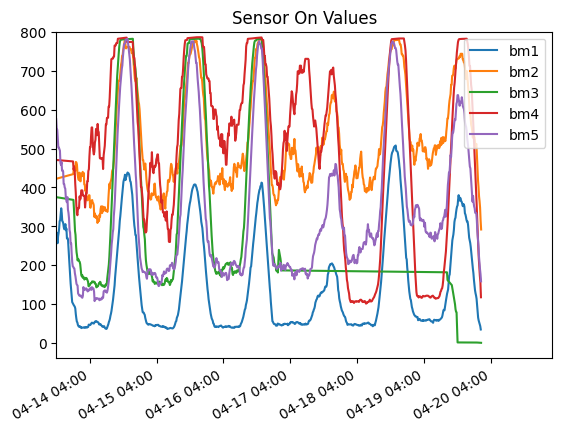

In [ ]:
# checking laser on values for all sensors
date_fmt = '%m-%d %H:%M'
# Use DateFormatter to set the data to the correct format.
date_formatter = mdates.DateFormatter(date_fmt)


lower = datetime(2023, 4, 13, hour=16)
#plot
plt.figure()
plt.plot(bm1.d_dt, moving_average(bm1.on, 20))
plt.plot(bm2.d_dt, moving_average(bm2.on, 20))
plt.plot(bm3.d_dt, moving_average(bm3.on, 20))
plt.plot(bm4.d_dt, moving_average(bm4.on, 20))
plt.plot(bm5.d_dt, moving_average(bm5.on, 20))
plt.xlim(left=lower)
plt.ylim(top=800)
plt.title("Sensor On Values")
plt.legend(['bm1','bm2', 'bm3', 'bm4', 'bm5'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.show()

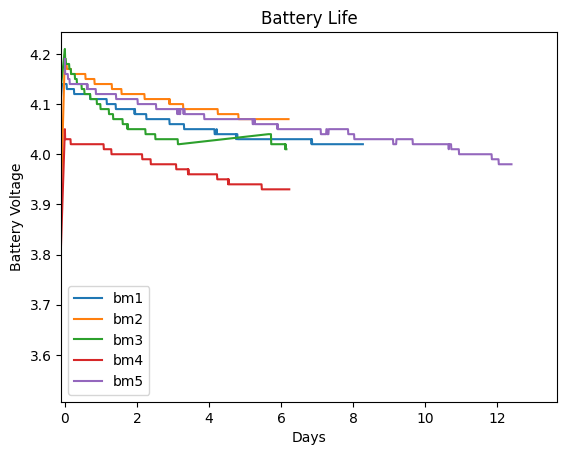

In [ ]:
# checking battery life
bm1_t = mdates.date2num(bm1.s_dt)
bm2_t = mdates.date2num(bm2.s_dt)
bm3_t = mdates.date2num(bm3.s_dt)
bm4_t = mdates.date2num(bm4.s_dt)
bm5_t = mdates.date2num(bm5.s_dt)

bm1_start = bm1_t[1633]
bm2_start = bm2_t[812]
bm3_start = bm3_t[723]
bm4_start = bm4_t[755]
bm5_start = bm5_t[0]


bm1_t = bm1_t - bm1_start
bm2_t = bm2_t - bm2_start
bm3_t = bm3_t - bm3_start
bm4_t = bm4_t - bm4_start
bm5_t = bm5_t - bm5_start

t = np.arange(1, len(bm2.battv) + 1) / 6 / 24
plt.figure()
plt.plot(bm1_t, bm1.battv)
plt.plot(bm2_t, bm2.battv)
plt.plot(bm3_t, bm3.battv)
plt.plot(bm4_t, bm4.battv)
plt.plot(bm5_t, bm5.battv)
plt.xlim(left=-.1)
plt.title("Battery Life")
plt.ylabel("Battery Voltage")
plt.xlabel("Days")
plt.legend(["bm1", "bm2", "bm3", "bm4", "bm5"], loc='lower left')
plt.show()

Int64Index([9, 10, 11], dtype='int64')
r
i
i


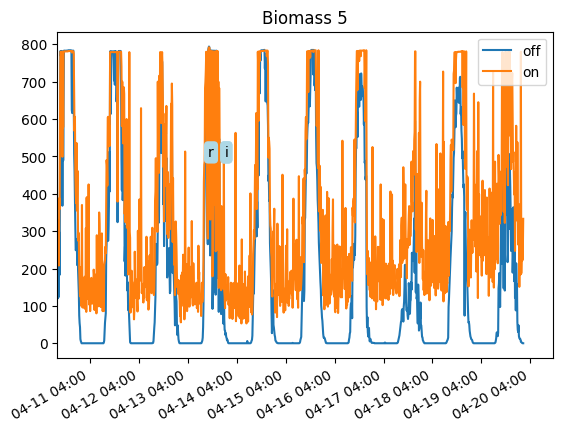

In [ ]:
id = 5
bmx = bm5
lower = datetime(2023, 4, 10, hour=12)
#plot
plt.figure()
plt.plot(bmx.d_dt, bmx.off)
plt.plot(bmx.d_dt, bmx.on)
plt.xlim(left=lower)
# plt.ylim(top=400)
plt.title("Biomass " + str(id))
plt.legend(['off', 'on'])
plt.gcf().autofmt_xdate()
plt.gca().xaxis.set_major_formatter(date_formatter)

#plot anomalies 
bmx_anomalies = df_anomaly.index[df_anomaly.ID == id]
print(bmx_anomalies)
for i in bmx_anomalies:
    print(df_anomaly.Event[i])
    text = str(df_anomaly.Event[i])
    pos = df_anomaly.datetime[i]
    plt.text(pos, 500, text,
                bbox=dict(boxstyle="round,pad=0.3", ec='none', fc='lightblue'))
plt.show()

#Deleting Data from Firebase
WARNING: this action will permanently alter the data in Firebase.

In [ ]:
# #select sensor and data or status path
# del_path = '/bmass_5/data'
# del_node = db.reference(del_path)
# #select start date for delete 
# del_start = datetime(2023, 4, 13, hour=10, minute=0)
# #select end date for delete
# del_end = datetime(2023, 4, 13, hour=18, minute=0)

# del_data = del_node.get()
# del_data_dt = []
# print("Deleting the Following Nodes: ", del_path)
# for i in del_data:
#     i_dt = datetime.fromisoformat(i)
#     if (del_start <= i_dt <= del_end):
#         print(i)
#         del_data_dt.append(i)
        
# #uncomment the following section to delete
# print("Should these nodes be deleted? (y/n)")
# # if (input('permanently delete (y/n): ') == 'y'):
# #     for i in del_data_dt:
# #         del_point = del_path + '/' + i
# #         del_point = db.reference(del_point)
# #         del_point.delete()

# Prediction Models


In [ ]:
pip install scalecast --upgrade

In [ ]:
# pred_data = moving_average(bm5.off,20)
dates = pd.to_datetime(bm5.d_dt)
values = bm5.on
df = pd.DataFrame({'ds': dates, 'y': values})

In [ ]:
df['ds'] = df['ds'].dt.tz_localize(None)

In [ ]:
from scalecast.Forecaster import Forecaster
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

In [ ]:
f = Forecaster(
    y = df['y'],
    current_dates= df['ds']
)

In [ ]:
f

Forecaster(
    DateStartActuals=2023-04-07T14:12:30.000000000
    DateEndActuals=2023-04-19T20:29:37.000000000
    Freq=None
    N_actuals=1534
    ForecastLength=0
    Xvars=[]
    TestLength=0
    ValidationMetric=rmse
    ForecastsEvaluated=[]
    CILevel=None
    CurrentEstimator=mlr
    GridsFile=Grids
)

/usr/local/lib/python3.9/dist-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


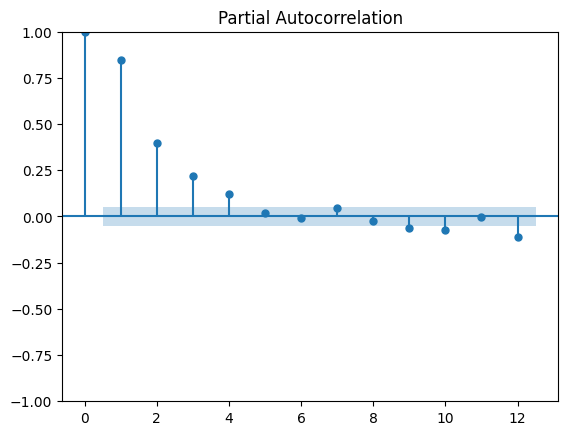

In [ ]:
f.plot_pacf(lags=12)
plt.show()

The PACF shows statistical correlation in 1 day values

# Augmented Dickey-Fuller test

This test is to see if the series is stationary or non-stationary

In [ ]:
stat, pval, _, _, _, _ = f.adf_test()

In [ ]:
print(f'Stat: {stat}')
print(f'P-value: {pval}')

Stat: -7.382044111572893
P-value: 8.422768222032365e-11


As P-value is less than 0.05, the series can be assumed stationary

# ARIMA Forecasting

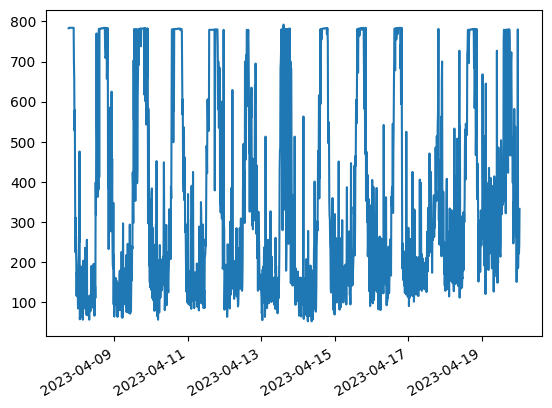

In [ ]:
value = pd.Series(bm5.on)
dates = pd.to_datetime(bm5.d_dt)
value.index = pd.DatetimeIndex(dates).tz_convert('UTC')
value.plot()
plt.show()


Determine the order of the AR and MA terms (p and q) for the ARIMA model using the autocorrelation function (ACF) and partial autocorrelation function (PACF):

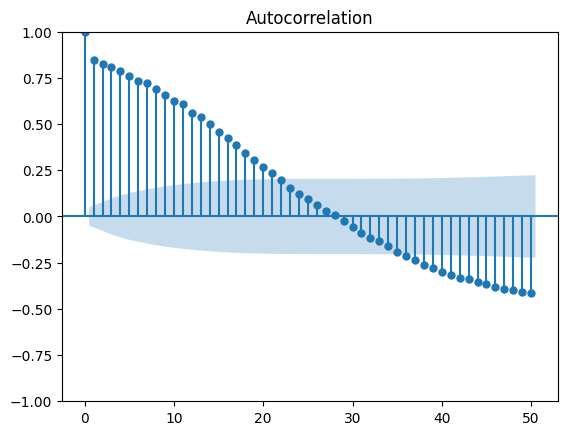

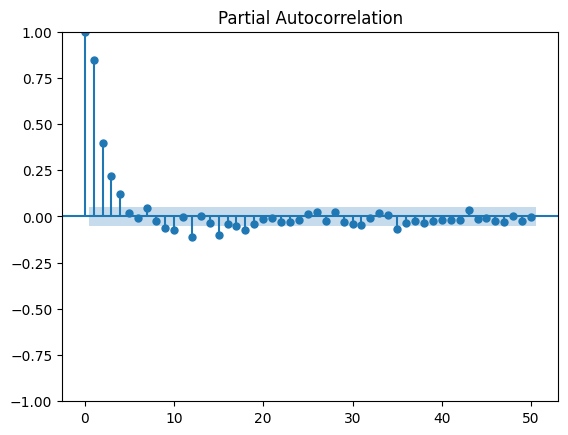

In [ ]:
sm.graphics.tsa.plot_acf(values, lags=50)
plt.show()

sm.graphics.tsa.plot_pacf(value, lags=50)
plt.show()

In [ ]:
p,q,d = 1,0,1
model = ARIMA(value, order=(p, d, q))
results = model.fit()
print(results.summary())

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1534
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -9535.761
Date:                Thu, 20 Apr 2023   AIC                          19075.521
Time:                        03:04:44   BIC                          19086.191
Sample:                             0   HQIC                         19079.492
                               - 1534                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4429      0.016    -27.677      0.000      -0.474      -0.411
sigma2      1.481e+04    337.765     43.857      0.000    1.42e+04    1.55e+04
Ljung-Box (L1) (Q):                  18.23   Jarque-

In [ ]:
bm5_df = pd.DataFrame({'laser_on': bm5.on}, index=pd.to_datetime(bm5.d_dt))
train_size = int(len(bm5_df) * 0.85)
train, test = bm5_df.iloc[:train_size], bm5_df.iloc[train_size:]
# from pmdarima.arima import auto_arima
# model = auto_arima(train, trace=True,  suppress_warnings=True)
# predictions = model.predict(n_periods=len(test))
# plt.plot(test, color='green')
# plt.plot(train)
# plt.plot(predictions, color='red')
# plt.show()

ARIMA being a complex model is being overfitted to the data in the auto_arima api model as the data we have is very less for such a complex model


# Moving Average Forecast model

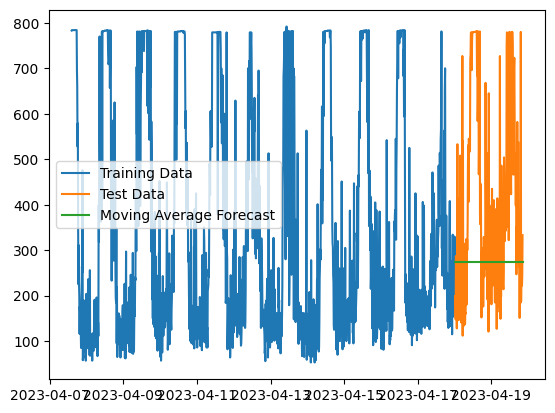

In [ ]:
from statsmodels.tsa.api import SimpleExpSmoothing, ExponentialSmoothing

# Moving Averag8 (MA) model
window_size = 2
ma_predictions = test.copy()
ma_predictions['forecast'] = train['laser_on'].rolling(window_size).mean().iloc[-1]
plt.plot(train['laser_on'], label='Training Data')
plt.plot(test['laser_on'], label='Test Data')
plt.plot(ma_predictions['forecast'], label='Moving Average Forecast')
plt.legend()
plt.show()

 # Exponential Smoothing model

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


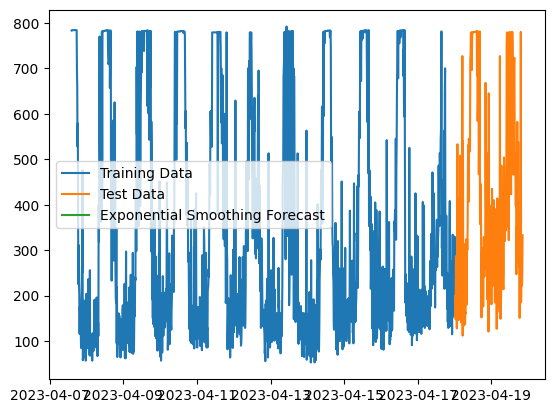

In [ ]:
alpha = 0.2 # smoothing constant
es_model = SimpleExpSmoothing(train['laser_on']).fit(smoothing_level=alpha)
es_predictions = test.copy()
es_predictions['forecast'] = es_model.forecast(len(test))
plt.plot(train['laser_on'], label='Training Data')
plt.plot(test['laser_on'], label='Test Data')
plt.plot(es_predictions['forecast'], label='Exponential Smoothing Forecast')
plt.legend()
plt.show()


In [ ]:
bm5_df

,laser_on
2023-04-07 14:12:30-04:00,783
2023-04-07 14:24:15-04:00,784
2023-04-07 14:35:47-04:00,784
2023-04-07 14:47:18-04:00,784
2023-04-07 14:58:50-04:00,784
...,...
2023-04-19 19:43:42-04:00,243
2023-04-19 19:55:11-04:00,306
2023-04-19 20:06:40-04:00,222
2023-04-19 20:18:08-04:00,244


In [ ]:
import pandas as pd
from prophet import Prophet

# Create a DataFrame with the dates and values
dates = pd.to_datetime(bm5.d_dt)
values = bm5.on
df = pd.DataFrame({'ds': dates, 'y': values})

# Create a Prophet model
model = Prophet()

# Fit the model to the data
df['ds'] = df['ds'].dt.tz_localize(None) # Remove timezone from ds column
model.fit(df)

# Make predictions for the next 12 hours
future = model.make_future_dataframe(periods=12, freq='H')
forecast = model.predict(future)

# Print the forecasted values
print(forecast[['ds', 'yhat']].tail(12))


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8mxfb6x/lh8pu0uk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpr8mxfb6x/ub1gxgpy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=95217', 'data', 'file=/tmp/tmpr8mxfb6x/lh8pu0uk.json', 'init=/tmp/tmpr8mxfb6x/ub1gxgpy.json', 'output', 'file=/tmp/tmpr8mxfb6x/prophet_modelzgryf3up/prophet_model-20230420024428.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
02:44:28 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
02:44:28 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


                      ds        yhat
1534 2023-04-19 21:29:37  231.502473
1535 2023-04-19 22:29:37  237.810490
1536 2023-04-19 23:29:37  224.872670
1537 2023-04-20 00:29:37  207.359372
1538 2023-04-20 01:29:37  206.675652
1539 2023-04-20 02:29:37  224.488749
1540 2023-04-20 03:29:37  239.640817
1541 2023-04-20 04:29:37  232.576151
1542 2023-04-20 05:29:37  212.298131
1543 2023-04-20 06:29:37  216.597590
1544 2023-04-20 07:29:37  281.864755
1545 2023-04-20 08:29:37  409.246865


# LSTM model

In [ ]:
f.set_test_length(50)       # 1. 50 observations to test the results
f.generate_future_dates(36) # 2. 36 future points to forecast
f.set_estimator('lstm')     # 3. LSTM neural network

47/47 [==============================] - 0s 2ms/step


/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

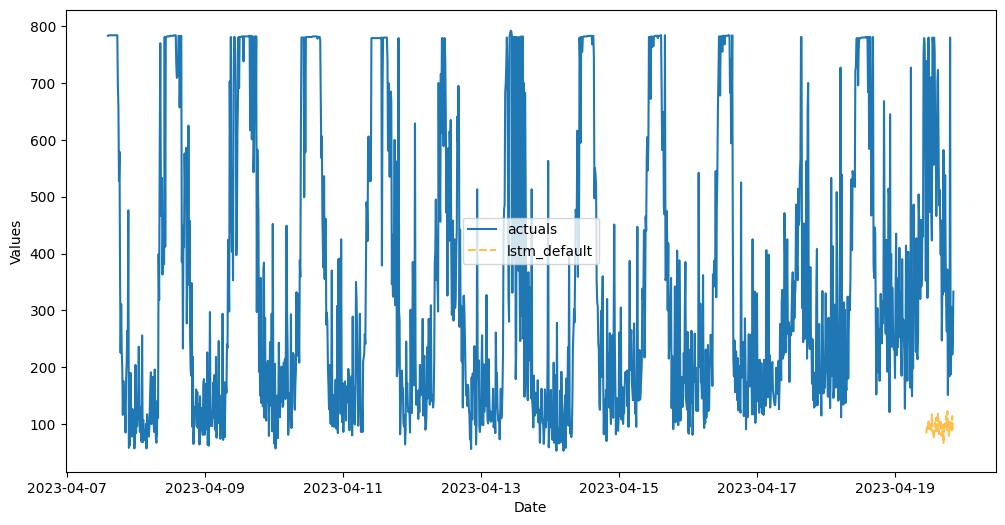

In [ ]:
f.manual_forecast(call_me='lstm_default')
f.plot_test_set(ci=True)

47/47 [==============================] - 0s 4ms/step


/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

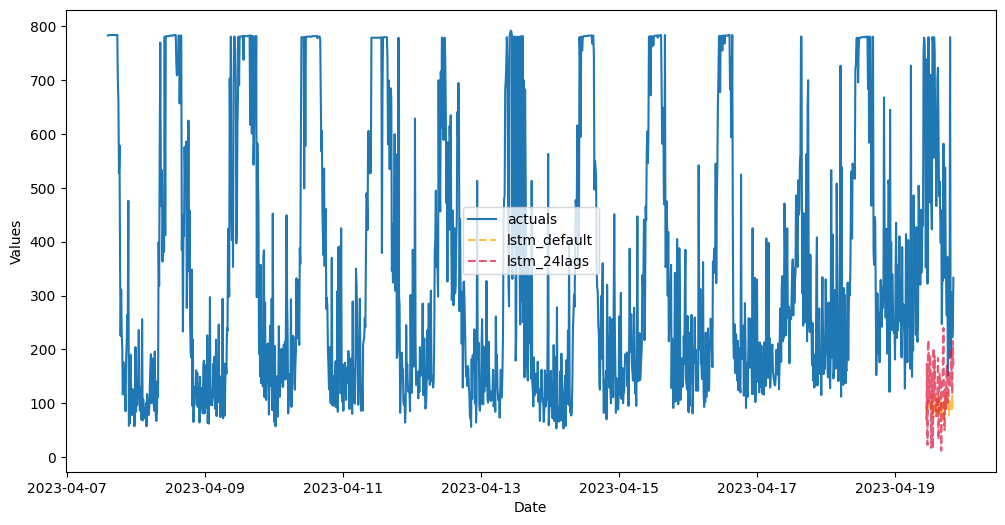

In [ ]:
f.manual_forecast(call_me='lstm_24lags',lags=24)
f.plot_test_set(ci=True)

Epoch 1/15
36/36 [==============================] - 7s 31ms/step - loss: 0.3719 - val_loss: 0.3102
Epoch 2/15
36/36 [==============================] - 1s 17ms/step - loss: 0.3131 - val_loss: 0.2332
Epoch 3/15
36/36 [==============================] - 1s 17ms/step - loss: 0.2817 - val_loss: 0.2094
Epoch 4/15
36/36 [==============================] - 1s 18ms/step - loss: 0.2709 - val_loss: 0.2053
Epoch 5/15
36/36 [==============================] - 1s 18ms/step - loss: 0.2641 - val_loss: 0.2087
Epoch 6/15
36/36 [==============================] - 1s 18ms/step - loss: 0.2587 - val_loss: 0.2127
Epoch 7/15
36/36 [==============================] - 1s 18ms/step - loss: 0.2533 - val_loss: 0.2112
Epoch 8/15
36/36 [==============================] - 1s 19ms/step - loss: 0.2487 - val_loss: 0.2145
Epoch 9/15
36/36 [==============================] - 1s 18ms/step - loss: 0.2445 - val_loss: 0.2135
Epoch 10/15
36/36 [==============================] - 1s 17ms/step - loss: 0.2408 - val_loss: 0.2137
Epoch 11/

/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_5epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_15epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(


<Axes: xlabel='Date', ylabel='Values'>

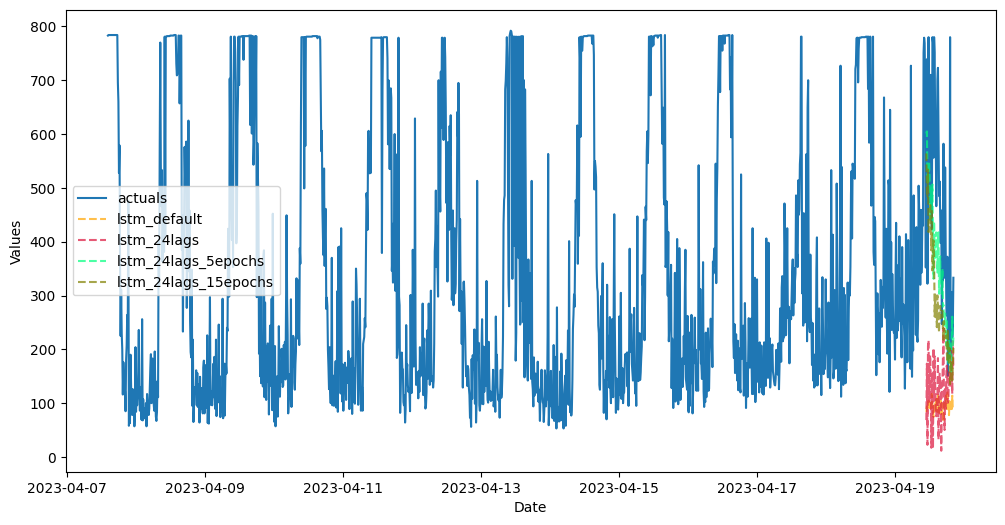

In [ ]:
f.manual_forecast(
    call_me='lstm_24lags_15epochs',
    lags=24,
    epochs=15,
    validation_split=.2,
    shuffle=True,
)
f.plot_test_set(ci=True)

Epoch 1/25
36/36 [==============================] - 11s 77ms/step - loss: 0.3566 - val_loss: 0.2708
Epoch 2/25
36/36 [==============================] - 1s 41ms/step - loss: 0.2963 - val_loss: 0.2088
Epoch 3/25
36/36 [==============================] - 1s 40ms/step - loss: 0.2756 - val_loss: 0.2038
Epoch 4/25
36/36 [==============================] - 1s 41ms/step - loss: 0.2578 - val_loss: 0.2031
Epoch 5/25
36/36 [==============================] - 1s 41ms/step - loss: 0.2324 - val_loss: 0.2072
Epoch 6/25
36/36 [==============================] - 2s 58ms/step - loss: 0.2137 - val_loss: 0.2267
Epoch 7/25
36/36 [==============================] - 2s 56ms/step - loss: 0.2042 - val_loss: 0.2145
Epoch 8/25
36/36 [==============================] - 1s 39ms/step - loss: 0.1987 - val_loss: 0.2041
Epoch 9/25
1/1 [==============================] - 1s 1s/step
Epoch 1/25
37/37 [==============================] - 11s 81ms/step - loss: 0.3323 - val_loss: 0.3043
Epoch 2/25
37/37 [============================

/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_default. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_5epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confidence intervals not found for lstm_24lags_15epochs. To turn on confidence intervals for future evaluated models, call the eval_cis() method.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/scalecast/_utils.py:55: Warning: Confid

<Axes: xlabel='Date', ylabel='Values'>

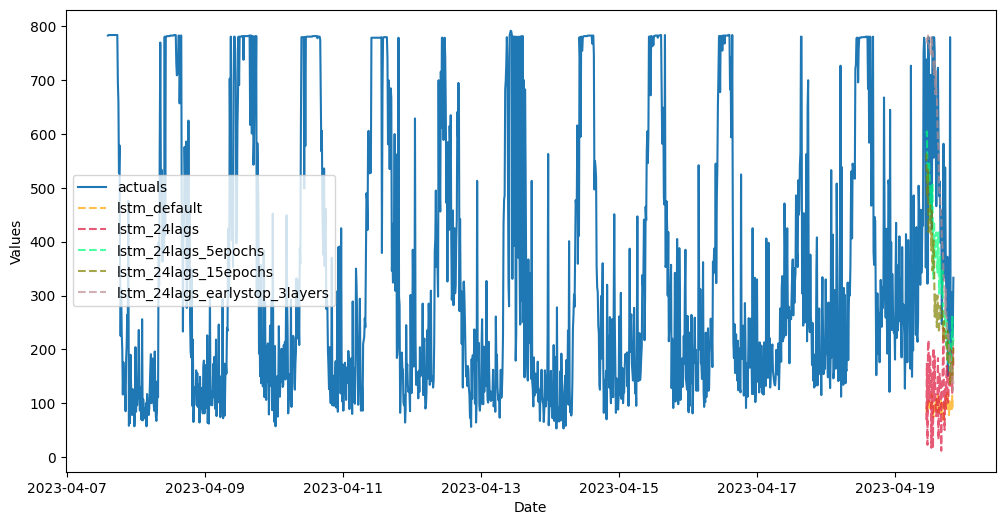

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

f.manual_forecast(
    call_me='lstm_24lags_earlystop_3layers',
    lags=24,
    epochs=25,
    validation_split=.2,
    shuffle=True,
    callbacks=EarlyStopping(
        monitor='val_loss',               
        patience=5,
    ),
    lstm_layer_sizes=(16,16,16),
    dropout=(0,0,0),
)

f.plot_test_set(ci=True)